In [120]:
import numpy as np
from numpy import linalg as LA

from scipy import arange, conj, prod
import scipy.sparse.linalg as ssl

import matplotlib.pyplot as plt

import qutip as qt
from qutip import Qobj, tensor


from statistics import mean
import importlib

import pickle

import os

import scipy as sp


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


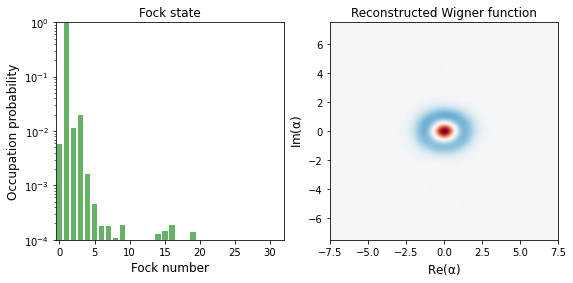

In [121]:
# load array of qutip density operators
import os
from matplotlib import pyplot as plt
import numpy as np
import qutip as qt


#here = os.path.dirname(os.path.abspath(__file__))
here=os.getcwd()
rho_fock1_reconstructed = qt.Qobj(np.load(os.path.join(here, "data", "rho_reconstructed_fock1_61x61.npy"), allow_pickle=True))

# plot wigner function

def plot_reconstruction(rho):
    fig, ax = qt.plot_wigner_fock_distribution(rho, figsize=(9, 4))
    ax[0].set_title("Fock state")
    ax[1].set_title("Reconstructed Wigner function")
    ax[0].set_yscale("log")
    ax[0].set_ylim([1e-4, 1])
    plt.show()


plot_reconstruction(rho_fock1_reconstructed)



# increase the fock dimention to odd number to have a better simulation of post-selecting measurement on q=0

In [126]:
#Qobj to numpy array / matrix:
q=rho_fock1_reconstructed
data = q.full()
array = np.array(data)
#add 0to the matrix
array_new=np.zeros((33,33),array.dtype)
array_new[:-1,:-1]=array
q = Qobj(array_new)
q=q.unit()
#q = Qobj(matrix)

In [128]:
def beam_splitter(theta: float, phi: float, n_truncate: int)->qt.Qobj:
    """Generates the beam splitter operator.

    Args:
        theta (float): _description_
        phi (float): _description_
        n_truncate (int): Fock space truncation.

    Returns:
        bs_hamiltonian (qt.Qobj): The beam splitter operator.
    """
    a1 = qt.destroy(n_truncate)
    a2 = qt.destroy(n_truncate)
    bs_hamiltonian = (theta * (np.exp(1j*phi)*tensor(a1,a2.dag())-np.exp(-1j*phi)*tensor(a1.dag(),a2))).expm()
    return bs_hamiltonian

def beam_qp(bs_h: qt.Qobj, in1: qt.Qobj, in2: qt.Qobj, in1_prob: float, 
            in2_prob: float, target_dm: qt.Qobj, n_truncate: int, m1_ket: qt.Qobj, m1_value: float):
    """Runs a beamsplitter circuit

    Args:
        bas_h (qt.Qobj): the operater of a beamsplitter
        in1 (qt.Qobj): the state that is feeded into the beamsplitter in the first row
        in2 (qt.Qobj): the state that is feeded into the beamsplitter in the second row
        in1_prob (float): the probability of the state in1 in the previous round
        in2_prob (float): the probability of the state in2 in the previous round
        target_dm (qt.Qobj): the density matrix of the target state.
        n_truncate (int): Fock space truncation.
        m1_ket (qt.Qobj): eigenvector of the measurement1
        m1_value (float): eigenvalue of the measurement1

    Returns:
        res (dict): The dictionary of results.
    """
    mode12 = tensor(in1,in2)
    
    out_12 = bs_h * mode12*bs_h.dag()


    M1 = m1_ket*m1_ket.dag()
    M12 = tensor(M1, qt.qeye(n_truncate))# go outside

    out12_m = M12*out_12*M12.dag()
    out2_dm = out12_m.ptrace(1)
    

    # from Nielsen and Chuang 2.103
    # qutip: ptrace(0):means we will trace (1) and keep everything in 0
    out2_dm = out2_dm.unit()
    out2_fid = qt.fidelity(target_dm, out2_dm)

    tailnorm  =  ssl.norm(out2_dm.data[n_truncate-10:n_truncate-1,:])
    if tailnorm >= 0.01:
        print('warning: tailnorm = ',tailnorm)

    out2_prob_v = (M12.dag()*M12*out_12).tr()
    #nielson 2.141
    out2_prob = in1_prob*in2_prob*out2_prob_v*2

    #since there is a symmetry between this 
    res = {'m1_ket':m1_ket,'m1_value':m1_value,'out2_dm': out2_dm,'out2_prob': out2_prob,'out2_fid':out2_fid}
    return res

In [ ]:
# circuit preparation
bs_h = beam_splitter(theta=np.pi/4, phi=0, n_truncate=n_truncate)
qp_bound = 5

Q = qt.position(n_truncate)
MeasQ = Q.eigenstates()
eigv_Q = MeasQ[0]
eigvec_Q = MeasQ[1]

P = qt.momentum(n_truncate)
MeasP = P.eigenstates()
eigv_P = MeasP[0]
eigvec_P = MeasP[1]


#  input states: Perfect fock state vector

input1


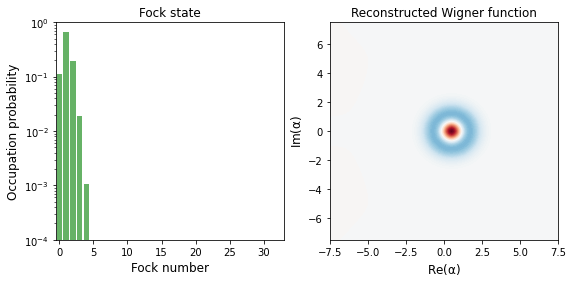

input2


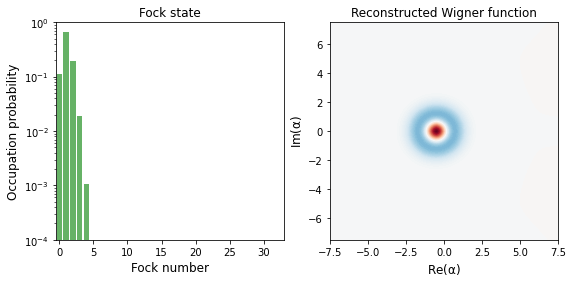

target_plot


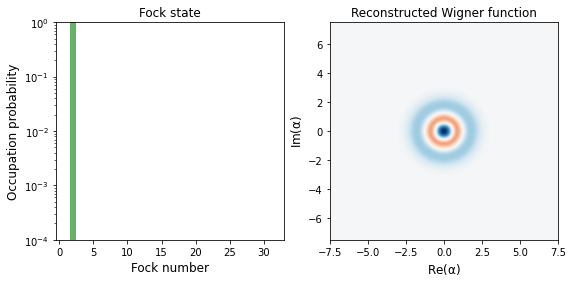

output state plot


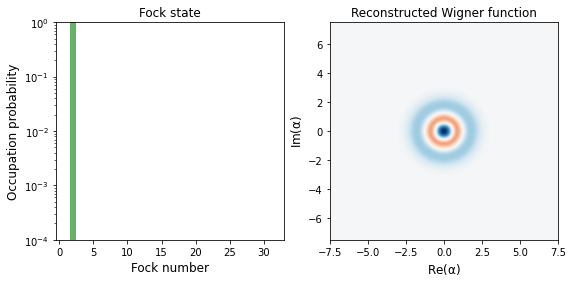

out2_prob= 0.13133065195167487
out2_fid= 1.0


In [142]:

dv=0.5/np.sqrt(2)
n_truncate=33
displace_op_positive=qt.displace(n_truncate,dv)
displace_op_negative=qt.displace(n_truncate,-dv)

fock1_dm=qt.fock(n_truncate, n=1, offset=None)*qt.fock(n_truncate, n=1, offset=None).dag()

fock1a_dm=displace_op_positive*fock1_dm*displace_op_positive.dag()
fock1a_dm=fock1a_dm.unit()
print('input1')
plot_reconstruction(fock1a_dm)


fock1b_dm=displace_op_negative*fock1_dm*displace_op_negative.dag()
fock1b_dm=fock1b_dm.unit()
print('input2')
plot_reconstruction(fock1b_dm)

fock2=qt.fock(n_truncate, n=2, offset=None).unit()
print('target_plot')
plot_reconstruction(fock2)


in1_prob=1
in2_prob=1
in1_ket =fock1a_dm
in2_ket=fock1b_dm


target=fock2*fock2.dag()
m=eigvec_Q[int(n_truncate/2)]

test = beam_qp(bs_h,in1_ket,in2_ket,in1_prob,in2_prob,target,n_truncate,m1_ket = m,m1_value = 0)
title_add='fig/fock44'
print('output state plot')
plot_reconstruction(test['out2_dm'])
print('out2_prob=',test['out2_prob'])
print('out2_fid=',test['out2_fid'])


In [154]:
target=fock2*fock2.dag()
qt.fidelity(target,fock1_dm)


0.0

In [157]:
fock1_dm=qt.fock(n_truncate, n=1, offset=None)*qt.fock(n_truncate, n=1, offset=None).dag()
target


Quantum object: dims = [[33], [33]], shape = (33, 33), type = oper, isherm = True
Qobj data =
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

# experimental data

input1


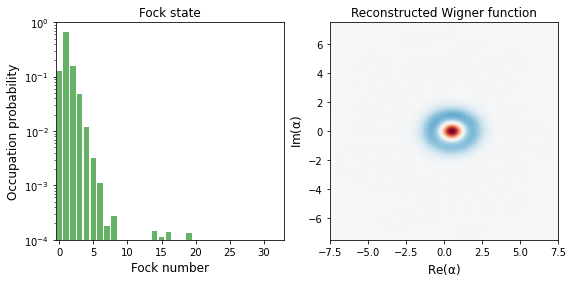

input2


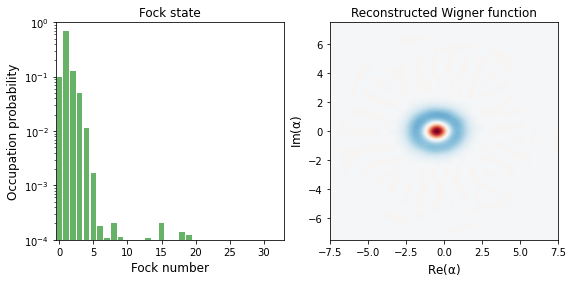

target_plot


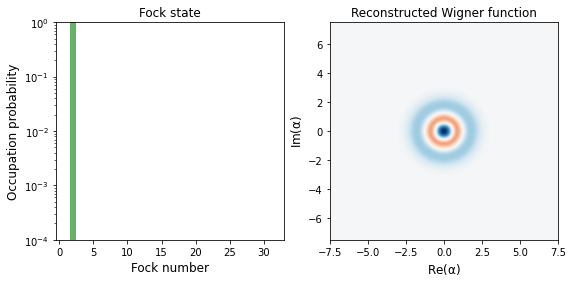

output state plot


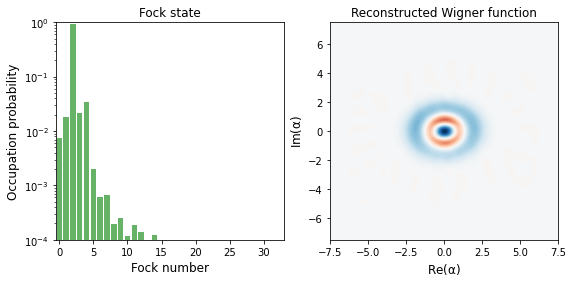

out2_prob= (0.13316075962176577-5.40964901379508e-14j)
out2_fid= 0.9561507980540659


In [144]:
# two coherent state are put into beam-splitter 


lab_fock1_dm=q

lab_fock1a_dm=displace_op_positive*lab_fock1_dm*displace_op_positive.dag()
lab_fock1a_dm=fock1a_dm.unit()
print('input1')
plot_reconstruction(lab_fock1a_dm)


lab_fock1b_dm=displace_op_negative*lab_fock1_dm*displace_op_negative.dag()
lab_fock1b_dm=fock1b_dm.unit()
print('input2')
plot_reconstruction(lab_fock1b_dm)


print('target_plot')
plot_reconstruction(fock2)


in1_prob=1
in2_prob=1
in1_ket =lab_fock1a_dm
in2_ket=lab_fock1b_dm


m=eigvec_Q[int(n_truncate/2)]

test = beam_qp(bs_h,in1_ket,in2_ket,in1_prob,in2_prob,target,n_truncate,m1_ket = m,m1_value = 0)
title_add='fig/fock44'
print('output state plot')
plot_reconstruction(test['out2_dm'])
print('out2_prob=',test['out2_prob'])
print('out2_fid=',test['out2_fid'])
